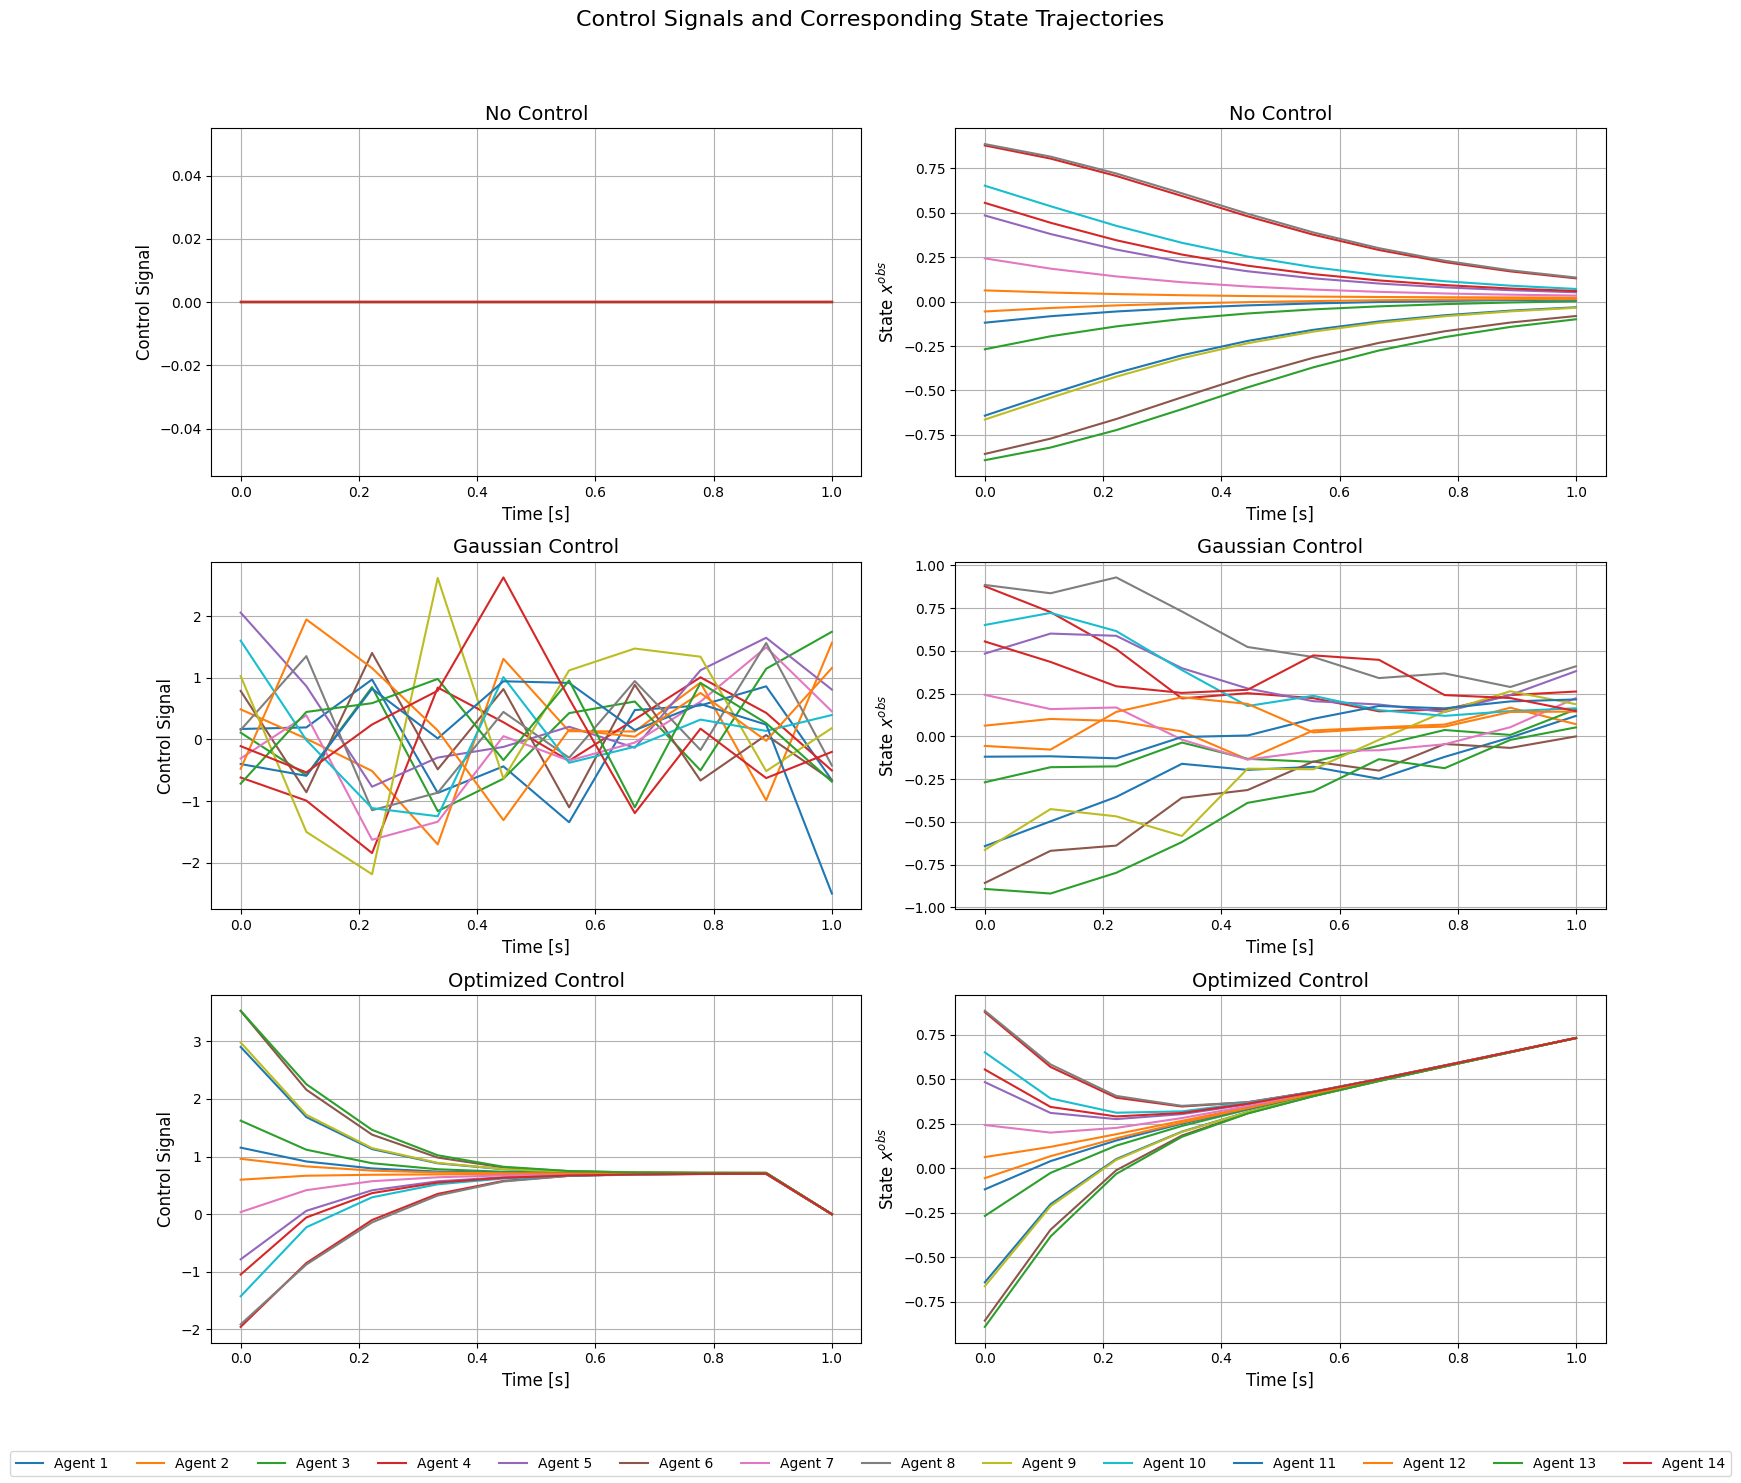

In [6]:
import jax
import jax.numpy as jnp
from jax import grad, jit
import optax  
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from sklearn.linear_model import OrthogonalMatchingPursuit, Lasso

seed = 45
key = jax.random.PRNGKey(seed)

# Parameters
n_agents = 14
n_steps = 10
true_theta_coefficients = jnp.array([0.2, 0, 0, -0.2, 0, 0])
# parameters gamma (weight by the the x - consensus), tau (target at terminal time), nu (weight by the target terminal state)
true_Omega_parameters = jnp.array([5, 0.75, 4])
T = 1

K_channels = n_agents  # can be changed to test the effect of media - type controls. In this project always equal to n_agents
t = jnp.linspace(0, T, n_steps)  # Time grid
dt = t[1] - t[0]

@jit
def func(x, u, theta):
    """
    Compute the forces acting on each particle given their positions, parameters (theta = (alpha, c)), and control values.

    Args:
        positions (list of float): A list of length N representing the positions of the particles at time t.
        theta (float of len 6): Parameters for the polynomial kernel.
        controls (list of float): A list of length N representing the control values at time t.

    Returns:
        list of float: A list of length N representing the forces acting on each particle at time t.
    """
    n = len(x)
    x_mean = jnp.mean(x)

    # Vectorized operations are faster in JAX. 
    # Note that this derivations are similar to what is needed for the Mean Field theory
    x_sq = x ** 2
    x_cube = x ** 3

    xi_part = (theta[0] + theta[1] * x + theta[3] * x_sq) * n * (x_mean - x)
    x_sq_sum = jnp.sum(x_sq)
    x_cube_sum = jnp.sum(x_cube)

    xj_part = (
        theta[2] * x * (n * x_mean - x_sq_sum) +
        theta[4] * (x * x_sq_sum - x_cube_sum) +
        theta[5] * (x_sq * jnp.sum(x) - x * x_sq_sum)
    )

    dynamics_part = xi_part + xj_part
    return dynamics_part + u

@jit
def rk4_step(x, u, dt, theta_coefficients):
    """Computes the next positions of the particles using the Runge-Kutta 4th order method

    Args:
        x (list of float): A list of length N representing the positions of the particles at time t.
        u (list of float): A list of length N representing the control values at time t.
        dt (float): time step
        theta_coefficients (float of len 6): Parameters for the polynomial kernel.

    Returns:
        (list of float): A list of length N representing the positions of the particles at time t + dt.
    """
    k1 = dt * func(x, u, theta_coefficients)
    k2 = dt * func(x + 0.5 * k1, u, theta_coefficients)
    k3 = dt * func(x + 0.5 * k2, u, theta_coefficients)
    k4 = dt * func(x + k3, u, theta_coefficients)
    return x + (k1 + 2*k2 + 2*k3 + k4) / 6

@jit
def forward_pass(x_0, u_grid, theta_coefficients):
    """Computes the positions of the particles at each time step using the Runge-Kutta 4th order method

    Args:
        x_0 (float of len N): initial postinions of the particles
        u_grid (float of dim N x (K+1)): control values at each time step and for each particle
        theta_coefficients (float of len 6): Parameters for the polynomial kernel.

    Returns:
        x_grid (float of dim N x (K+1)): positions of the particles at each time step
    """
    x_grid = jnp.zeros((n_agents, n_steps))
    x_grid = x_grid.at[:, 0].set(x_0)
    for i in range(1, n_steps):
        x = x_grid[:, i-1]
        u = u_grid[:, i-1]
        x_grid = x_grid.at[:, i].set(rk4_step(x, u, dt, theta_coefficients))
    return x_grid

def compute_J(x_grid, u_grid, theta_coefficients, Omega_parameters):
    """Computes the cost function J_Omega for a given trajectory, and parameters Omega

    Args:
        x_grid (float of dim N x (K+1)): positions of the particles at each time step
        u_grid (float of dim N x (K+1)): control values at each time step and for each particle
        theta_coefficients (float of len 6): Parameters for the polynomial kernel.
        Omega_parameters (float, float, float): scaled down parameters of the loss function

    Returns:
        float: the value of the cost functional J_Omega
    """
    # Rescale Omega parameters
    rescaled_Omega_parameters = jnp.array([10, 1, 10]) * Omega_parameters
    gamma, x_hat, nu = rescaled_Omega_parameters

    # Compute the running cost J
    x_means = jnp.mean(x_grid[:, :n_steps], axis=0)
    x_diffs = x_grid[:, :n_steps] - x_means
    u_squares = jnp.square(u_grid[:, :n_steps])

    running_j = dt * jnp.sum(gamma * jnp.sum(jnp.square(x_diffs), axis=0) + jnp.sum(u_squares, axis=0))

    # Handle the final step separately to compute the terminal cost
    x_final = x_grid[:, n_steps - 1]
    phi = nu * jnp.dot(x_final - x_hat, x_final - x_hat)

    # Compute the final cost J
    J = running_j + phi
    return J

@jit
def compute_loss(u, x_0, theta_coefficients, Omega_parameters):
    """calls on the forward pass and compute_J functions to compute the loss function

    Args:
        u (float vector): control values before reshaping into a matrix
        x_0 (float of len N): initial postinions of the particles
        theta_coefficients (float of len 6): Parameters for the polynomial kernel.
        Omega_parameters (float, float, float): scaled down parameters of the loss function

    Returns:
        float: the value of the cost functional J_Omega
    """
    u_grid = u.reshape((K_channels, n_steps))
    x_grid = forward_pass(x_0, u_grid, theta_coefficients)
    return compute_J(x_grid, u_grid, theta_coefficients, Omega_parameters)

def run_optimization(x_0, theta_coefficients, Omega_parameters):
    """finds the optimal control signal u

    Args:
        x_0 (float of len N): initial postinions of the particles
        theta_coefficients (float of len 6): Parameters for the polynomial kernel.
        Omega_parameters (float, float, float): scaled down parameters of the loss function J

    Returns:
        u (float vector): control values before reshaping into a matrix
    """
    optimizer = optax.adam(learning_rate=0.05)
    gradient_u = lambda u: grad(compute_loss, argnums=0)(u, x_0, theta_coefficients, Omega_parameters)

    max_iter = 100
    max_attempts = 10

    @partial(jit, static_argnums=(2,))
    def update_step(u, opt_state, n_agents):
        grads = gradient_u(u)
        updates, opt_state = optimizer.update(grads, opt_state)
        u = optax.apply_updates(u, updates)
        return u, opt_state

    u_init = jnp.zeros(K_channels * n_steps)
    opt_state = optimizer.init(u_init)
    u = u_init
    last_loss_values = []
    for i in range(max_iter):  # Number of optimization steps
        u, opt_state = update_step(u, opt_state, n_agents)
        if i > max_iter - 10:  # check convergence
            last_loss_values.append(compute_loss(u, x_0, theta_coefficients, Omega_parameters))

    have_converged = (max(last_loss_values) - min(last_loss_values)) / min(last_loss_values)
    attempts = 1
    while have_converged > 0.001:
        attempts += 1
        last_loss_values = []
        for i in range(max_iter):  # Number of optimization steps
            u, opt_state = update_step(u, opt_state, n_agents)
            if i > max_iter - 10:  # check convergence
                last_loss_values.append(compute_loss(u, x_0, theta_coefficients, Omega_parameters))
        have_converged = (max(last_loss_values) - min(last_loss_values)) / min(last_loss_values)
    return u

def find_u_grid(n_agents, n_steps, dt, x0, theta_coefficients, Omega_parameters):
    """calls on the run_optimization function to find the optimal control signal u, and reshapes it into a matrix

    Args:
        n_agents (int): N in the report, numer of agents
        n_steps (int): K in the reprt, number of time steps
        dt (float): time step
        x_0 (float of len N): initial postinions of the particles
        theta_coefficients (float of len 6): Parameters for the polynomial kernel.
        Omega_parameters (float, float, float): scaled down parameters of the loss function J

    Returns:
        N x (K+1) matrix of float: control values at each time step and for each particle
    """
    K_channels = n_agents
    u = run_optimization(x0, theta_coefficients, Omega_parameters)
    u_grid = u.reshape((K_channels, n_steps))
    return u_grid


#### helper functions for plotting ####
def plot_trajectories_and_controls(u_no_control, u_noise, u_optimized, x_no_control, x_noise, x_optimized, n_agents, t):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('Control Signals and Corresponding State Trajectories', fontsize=16)

    control_titles = ["No Control", "Gaussian Control", "Optimized Control"]
    trajectory_titles = ["No Control", "Gaussian Control", "Optimized Control"]

    u_grids = [u_no_control, u_noise, u_optimized]
    x_grids = [x_no_control, x_noise, x_optimized]

    for i in range(3):
        for j in range(n_agents):
            axes[i, 0].plot(t, u_grids[i][j], label='Agent ' + str(j + 1), linewidth=1.5)
            axes[i, 1].plot(t, x_grids[i][j], label='Agent ' + str(j + 1), linewidth=1.5)

        axes[i, 0].set_title(control_titles[i], fontsize=14)
        axes[i, 0].set_xlabel('Time [s]', fontsize=12)
        axes[i, 0].set_ylabel('Control Signal', fontsize=12)
        axes[i, 0].grid(True)

        axes[i, 1].set_title(trajectory_titles[i], fontsize=14)
        axes[i, 1].set_xlabel('Time [s]', fontsize=12)
        axes[i, 1].set_ylabel('State $x^{obs}$', fontsize=12)
        axes[i, 1].grid(True)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=n_agents, fontsize=10)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


### produce the observed data for different types of control signal ###

key, subkey = jax.random.split(key)
x0 = jax.random.uniform(subkey, (n_agents,), minval=-1, maxval=1)

u_optimized = find_u_grid(n_agents, n_steps, dt, x0, true_theta_coefficients, true_Omega_parameters)
x_optimized = forward_pass(x0, u_optimized, true_theta_coefficients)

u_no_control = np.zeros((n_agents, n_steps))
x_no_control = forward_pass(x0, u_no_control, true_theta_coefficients)

u_noise = np.random.normal(0, 1, (n_agents, n_steps))
x_noise = forward_pass(x0, u_noise, true_theta_coefficients)

plot_trajectories_and_controls(u_no_control, u_noise, u_optimized, x_no_control, x_noise, x_optimized, n_agents, t)


In [7]:
# For the 'corrupted observations experiment in the appendix'
# we introduce measurement noise for the state variable: corresponding to the potential difficulty in assessing the agents' optinions:

#noise_lvl = 0.05
#noise = np.random.normal(0, noise_lvl, (n_agents, n_steps))

#x_optimized = x_optimized + noise
#x_noise = x_noise + noise
#x_no_control = x_no_control + noise

In [8]:
def find_coefficientsl1(x, u, lasso_regularization):
  """ finds a sparse representation of the coefficients of the polynomial kernel using Lasso regression

    Args:
        x (float of dim N x (K+1)): observed positions of the particles at each time step
        u (float of dim N x (K+1)): observed control values at each time step and for each particle
        lasso_regularization (float): coefficient for the Lasso regularization

    Returns:
        (float of len 6): the coefficients of the polynomial kernel
  """

  # Estimate the derivatives using central difference method
  x_prime = np.zeros_like(x)

  # Central difference for interior points, forward/backward difference for boundaries
  for i in range(n_agents):
      x_prime[i, 1:-1] = (x[i, 2:] - x[i, :-2]) / (2 * dt)
      x_prime[i, 0] = (x[i, 1] - x[i, 0]) / dt
      x_prime[i, -1] = (x[i, -1] - x[i, -2]) / dt

  X = []
  Y = []
  for k in range(n_steps):
      for i in range(n_agents):
          row = np.zeros(6)
          for j in range(n_agents):
              row += np.array([1, x[i, k], x[j, k], x[i, k]**2, x[j, k]**2, x[i, k]*x[j, k]]) * (x[j, k] - x[i, k])

          X.append(row)
          Y.append(x_prime[i, k] - u[i,k])


  X = np.array(X)
  Y = np.array(Y)

  lasso = Lasso(alpha = lasso_regularization, max_iter = 10000)
  lasso.fit(X, Y)

  return lasso.coef_

# Computes the coefficients for different levels of regularization
regularization = [0.01, 0.02, 0.1, 0.5, 1]

res_no_control = []
res_noisy_control = []
res_optimal_control = []

for alpha in regularization:
    coeffs_no_control = find_coefficientsl1(x_no_control, u_no_control, alpha)
    coeffs_noisy_control = find_coefficientsl1(x_noise, u_noise, alpha)
    coeffs_optimal_control = find_coefficientsl1(x_optimized, u_optimized, alpha)

    res_no_control.append(coeffs_no_control)
    res_noisy_control.append(coeffs_noisy_control)
    res_optimal_control.append(coeffs_optimal_control)


In [9]:
def find_coefficients_l0(x, u, n_nonzero_coefs):
    """finds a sparse representation of the coefficients of the polynomial kernel using Orthogonal Matching Pursuit

    Args:
       x (float of dim N x (K+1)): observed positions of the particles at each time step
        u (float of dim N x (K+1)): observed control values at each time step and for each particle
        n_nonzero_coefs (int): number of non-zero coefficients to be selected

    Returns:
        (float of len 6): the coefficients of the polynomial kernel
    """

    # Estimate the derivatives using central difference method
    x_prime = np.zeros_like(x)

    # Central difference for interior points, forward/backward difference for boundaries
    for i in range(n_agents):
        x_prime[i, 1:-1] = (x[i, 2:] - x[i, :-2]) / (2 * dt)
        x_prime[i, 0] = (x[i, 1] - x[i, 0]) / dt
        x_prime[i, -1] = (x[i, -1] - x[i, -2]) / dt

    X = []
    Y = []
    for k in range(n_steps):
        for i in range(n_agents):
            row = np.zeros(6)
            for j in range(n_agents):
                row += np.array([1, x[i, k], x[j, k], x[i, k]**2, x[j, k]**2, x[i, k]*x[j, k]]) * (x[j, k] - x[i, k])
            X.append(row)
            Y.append(x_prime[i, k] - u[i, k])

    X = np.array(X)
    Y = np.array(Y)

    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
    omp.fit(X, Y)

    return omp.coef_

# Computes the coefficients for different levels of regularization
l0_regularization = [1,2,3,4]


l0res_no_control = []
l0res_noisy_control = []
l0res_optimal_control = []

for n_nonzero in l0_regularization:
    coeffs_no_control = find_coefficients_l0(x_no_control, u_no_control, n_nonzero)
    coeffs_noisy_control = find_coefficients_l0(x_noise, u_noise, n_nonzero)
    coeffs_optimal_control = find_coefficients_l0(x_optimized, u_optimized, n_nonzero)

    l0res_no_control.append(coeffs_no_control)
    l0res_noisy_control.append(coeffs_noisy_control)
    l0res_optimal_control.append(coeffs_optimal_control)


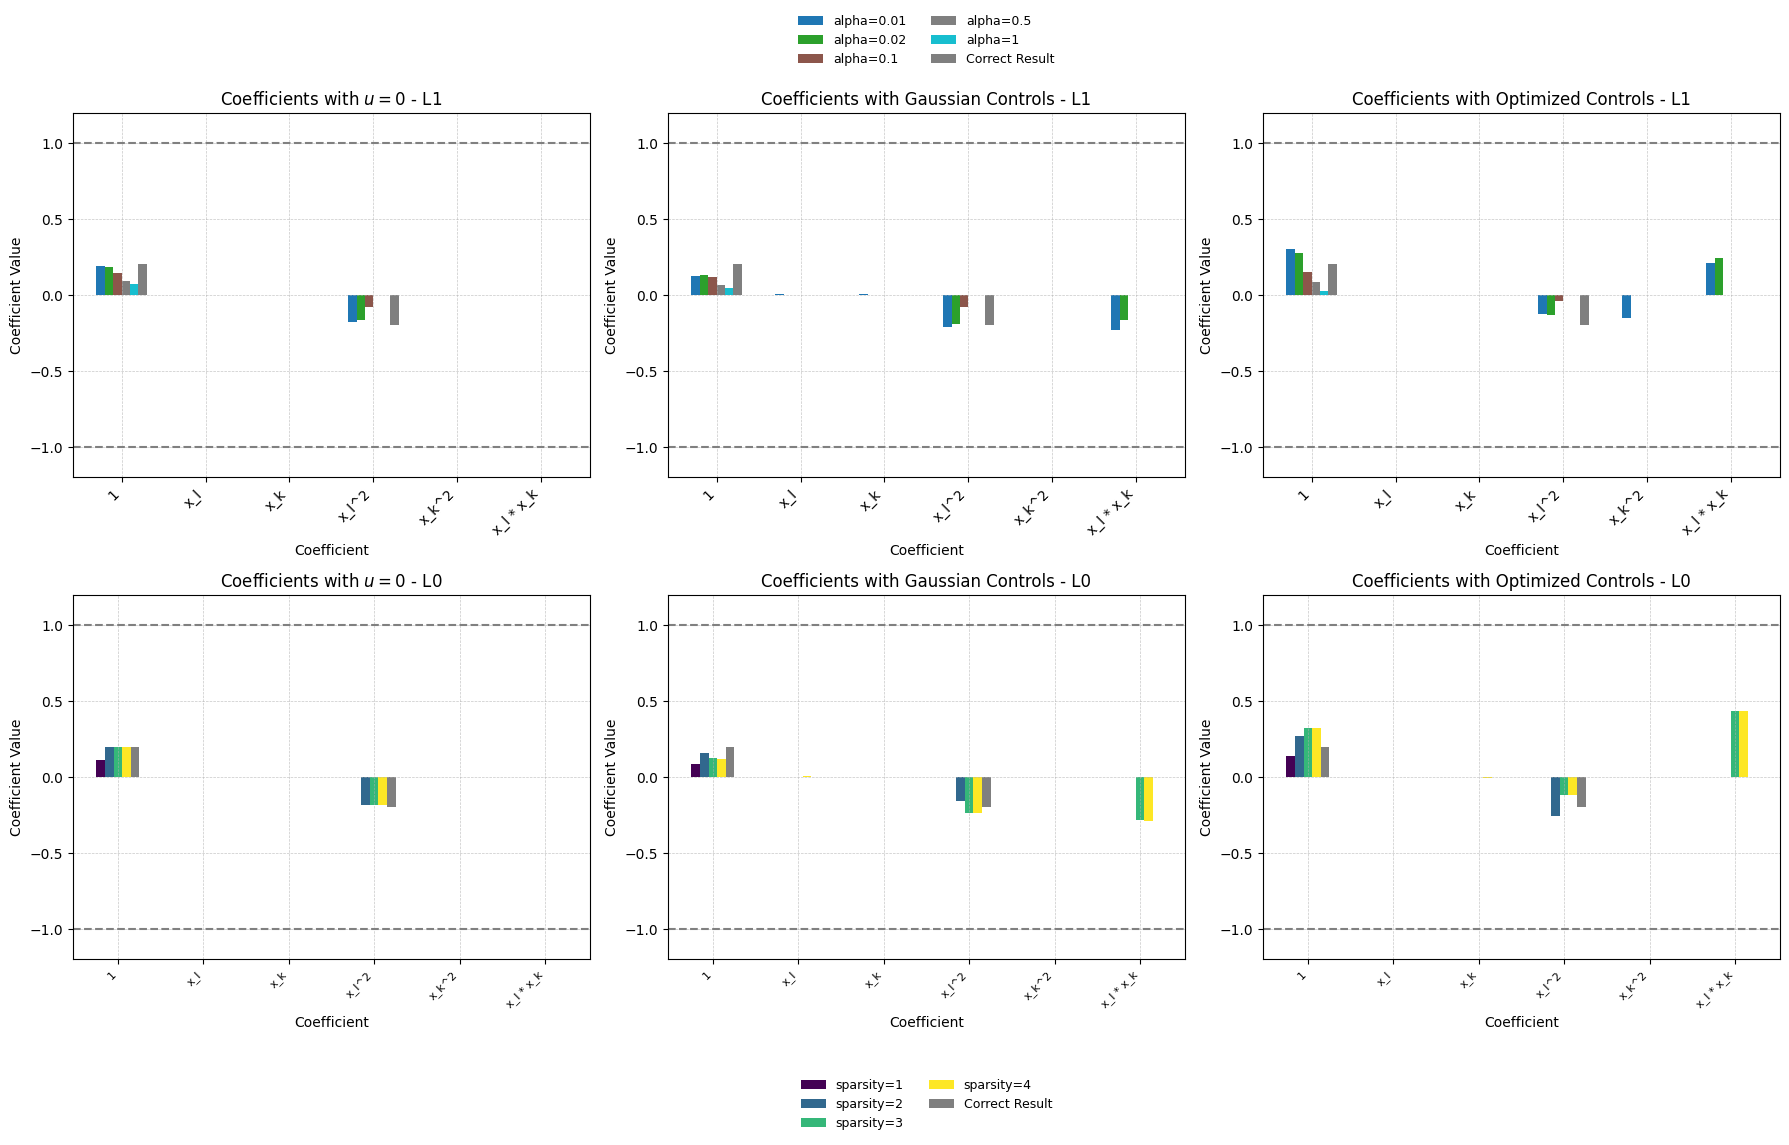

In [10]:
# Plotting the results for L0 and L1 and different levels of regularization
def plot_combined_coefficients(l1_coeffs, l0_coeffs, titles):
    coefficient_labels = [
        '1',
        'x_l',
        'x_k',
        'x_l^2',
        'x_k^2',
        'x_l * x_k'
    ]
    correct_result = np.array(true_theta_coefficients)

    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    bar_width = 0.1
    colors_l1 = plt.cm.tab10(np.linspace(0, 1, len(regularization)))
    colors_l0 = plt.cm.viridis(np.linspace(0, 1, len(l0_regularization)))

    for idx in range(3):
        # Plotting L1 results
        ax = axs[0, idx]
        for i, alpha in enumerate(regularization):
            ax.bar(np.arange(len(correct_result)) + i * bar_width, l1_coeffs[idx][i], bar_width, label=f'alpha={alpha}', color=colors_l1[i])
        ax.bar(np.arange(len(correct_result)) + len(regularization) * bar_width, correct_result, bar_width, color='k', alpha=0.5, label='Correct Result')
        ax.axhline(y=1, color='gray', linestyle='--')
        ax.axhline(y=-1, color='gray', linestyle='--')
        ax.set_xlabel('Coefficient')
        ax.set_ylabel('Coefficient Value')
        ax.set_xticks(np.arange(len(coefficient_labels)) + (len(regularization) / 2) * bar_width)
        ax.set_xticklabels(coefficient_labels, fontsize=10, rotation=45, ha='right')
        if idx == 1:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, fontsize=9, frameon=False)
        ax.set_title(titles[idx] + ' - L1', fontsize=12)
        ax.set_ylim([-1.2, 1.2])
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        # Plotting L0 results
        ax = axs[1, idx]
        for i, n_nonzero in enumerate(l0_regularization):
            ax.bar(np.arange(len(correct_result)) + i * bar_width, l0_coeffs[idx][i], bar_width, label=f'sparsity={n_nonzero}', color=colors_l0[i])
        ax.bar(np.arange(len(correct_result)) + len(l0_regularization) * bar_width, correct_result, bar_width, color='k', alpha=0.5, label='Correct Result')
        ax.axhline(y=1, color='gray', linestyle='--')
        ax.axhline(y=-1, color='gray', linestyle='--')
        ax.set_xlabel('Coefficient')
        ax.set_ylabel('Coefficient Value')
        ax.set_xticks(np.arange(len(coefficient_labels)) + (len(l0_regularization) / 2) * bar_width)
        ax.set_xticklabels(coefficient_labels, fontsize=8, rotation=45, ha='right')
        if idx == 1:
            ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=2, fontsize=9, frameon=False)
        ax.set_title(titles[idx] + ' - L0', fontsize=12)
        ax.set_ylim([-1.2, 1.2])
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

# Titles for the subplots
titles = [
    'Coefficients with $u = 0$',
    'Coefficients with Gaussian Controls',
    'Coefficients with Optimized Controls'
]

# Plotting the combined coefficients
plot_combined_coefficients([res_no_control, res_noisy_control, res_optimal_control],
                           [l0res_no_control, l0res_noisy_control, l0res_optimal_control],
                           titles)

